# Part 1: Automatic Speech Recognition, Diarize and Label

Environment = "whisperx"

* Performance Benchmarks on local
* GPU Benchmark: 0.09961056709289551 seconds
* Memory Bandwidth Benchmark: 0.2920224666595459 seconds
* CPU Benchmark: 13.046526432037354 seconds
* Disk Write Benchmark: 2.3364615440368652 seconds
* Disk Read Benchmark: 0.05882525444030762 seconds \n
  
** all benchmarks are >> faster than Collab with the exception of Disk write.

## Setup ⚙️
Tested for PyTorch 2.0, Python 3.10 (use other versions at your own risk!)
GPU execution requires the NVIDIA libraries cuBLAS 11.x and cuDNN 8.x to be installed on the system. Please refer to the CTranslate2 documentation.

1.  Create Python3.10 environment

`conda create --name whisperx python=3.10`

`conda activate whisperx`

2. Install PyTorch, e.g. for Linux and Windows CUDA11.8:
   
conda install pytorch==2.0.0 torchaudio==2.0.0 pytorch-cuda=11.8 -c pytorch -c nvidia

See other methods here.

1. Install this repo

`pip install git+https://github.com/m-bain/whisperx.git`

If already installed, update package to most recent commit

`pip install git+https://github.com/m-bain/whisperx.git --upgrade`

## Post Setup - REQUIRED for DIARIZATION
https://github.com/m-bain/whisperX/issues/499

`pip install pyannote.audio==3.0.1`

`pip uninstall onnxruntime`

`pip install --force-reinstall onnxruntime-gpu`

In [17]:
import ffmpeg

## 1 - Convert Mp3 to WAV.

def convert_m4a_to_mp3(input_file, output_file):
    try:
        ffmpeg.input(input_file).output(output_file).run(overwrite_output=True)
        print(f"Successfully converted {input_file} to {output_file}")
    except ffmpeg.Error as e:
        print("An error occurred:", e)

# Input/ output files and usage
input_mp3 = './audio/Botswana_2007_Audio.mp3'  # Change this to your mp3 file path
output_wav = './data/Botswana_2007_Audio.wav'  # Change this to your desired output wav file path

convert_m4a_to_mp3(input_mp3, output_wav)

Successfully converted ./audio/Botswana_2007_Audio.mp3 to ./data/Botswana_2007_Audio.wav


## Load the Audio File

In [6]:
import whisperx
import gc
import os
import torch

device = "cuda"
## Full file should be the input (2007 or 2024 file..)
audio_file = "./data/Botswana_2007_Audio.wav"

## DEBUGGING, use a small file
# audio_file = "./data/Intro.wav"

batch_size = 16 # reduce if low on GPU mem
compute_type = "float16" # change to "int8" if low on GPU mem (may reduce accuracy)
without_timestamps= 'True'

## Some error handling to ensure that successfully loaded the mp3 file!
try:
    # Check if the file exists
    if not os.path.isfile(audio_file):
        raise FileNotFoundError(f"The file '{audio_file}' does not exist.")
    # Optionally, you can add more checks (like file format) here

    print(f"Successfully accessed the audio file: {audio_file}")

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

c:\Users\jamie\miniconda3\envs\whisperx\lib\inspect.py:869: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
c:\Users\jamie\miniconda3\envs\whisperx\lib\site-packages\pyannote\audio\pipelines\speaker_verification.py:45: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import (


Successfully accessed the audio file: ./data/Botswana_2007_Audio.wav


# A) Transcribe and Diarize

## Single File processed
For large files, ie. the complete program, system crashed due to memory. Alternative approach is to break up audio files and iterate through them. See following section

In [20]:
import torch #if not already done
import gc

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"TRANSCRIBING Using device: {device}")

# 1. Transcribe with original whisper (batched)
model = whisperx.load_model("large-v2", device, compute_type=compute_type)

# save model to local path (optional)
model_dir = "./model/"
model = whisperx.load_model("large-v2", device, compute_type=compute_type, download_root=model_dir)

audio = whisperx.load_audio(audio_file)
result = model.transcribe(audio, batch_size=batch_size)
print(result["segments"]) # before alignment

# delete model if low on GPU resources
gc.collect(); torch.cuda.empty_cache(); del model



TRANSCRIBING Using device: cuda


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\jamie\.cache\torch\whisperx-vad-segmentation.bin`


No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.0. Bad things might happen unless you revert torch to 1.x.


c:\Users\jamie\miniconda3\envs\whisperx\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jamie\OneDrive\Data Science\Programming\WhisperX_Diarization\model\models--Systran--faster-whisper-large-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Lightning automatically upgraded your loaded checkpoint fro

No language specified, language will be first be detected for each audio file (increases inference time).
Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.0. Bad things might happen unless you revert torch to 1.x.
Detected language: en (0.99) in first 30s of audio...
[{'text': ' Hello, hello, and welcome. Thank you very much. Now, as you know, the producers on this show like to give us challenges, specifically where they give us a very small amount of money and tell us to buy a used car. Then they set unbelievably hard tasks to do to see which one of us got the best deal. Yeah. This week, for a Top Gear special, they came up with a real humdinger. They gave each of us 1,500 quid and told us to go to Africa and buy a car.', 'start': 21.067, 'end': 50.828}, {'text': " Yeah, there were just two conditions. It mustn't be four-wheel drive, and it mustn't be bu

In [ ]:
## SAVE the TRANSCRIPT
import json
with open('./outputs/Transcription_result.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)



In [ ]:
## DEBUGGING: Import the Transcript back in notebook

# Open and load the JSON file
with open('./outputs/Transcription_result.json', 'r') as file:
	data = json.load(file)

# Access and print the "segments"
Transcription_reimported = data["segments"]
print(Transcription_reimported)

## Transcription in Batches

### Split the Audio file into smaller pieces


In [ ]:
## 3 - Split up large files in <10min


import sqlite3
import librosa
import soundfile as sf
import math


# TODO: change max duration to 300 seconds
# TODO: update the target database folder
# TODO: check input filenames
# TODO: Update the output folder

# Function to split audio and save to database
def split_audio(audio_file, max_duration=300):  # 60second (1min) for testing; 300sec for production
    conn = sqlite3.connect('./data/Audio_clips.db')
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS clips
                     (id INTEGER PRIMARY KEY AUTOINCREMENT, start_time REAL, end_time REAL, filename TEXT)''')

    try:
        y, sr = librosa.load(audio_file)
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return []

    total_duration = librosa.get_duration(y=y, sr=sr)
    num_splits = math.ceil(total_duration / max_duration)
    results = []

    for i in range(num_splits):
        start_time = i * max_duration
        end_time = min((i + 1) * max_duration, total_duration)

        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)

        clip = y[start_sample:end_sample]
        filename = f"./data/Botswana2007_clip_{i}.wav"

        try:
            sf.write(filename, clip, sr)
            cursor.execute("INSERT INTO clips (start_time, end_time, filename) VALUES (?, ?, ?)",
                           (start_time, end_time, filename))
            conn.commit()
            results.append({"start_time": start_time, "end_time": end_time, "filename": filename})
        except Exception as e:
            print(f"Error processing clip {i}: {e}")

    conn.close()
    return results
# results is a DIctionary
results = split_audio(audio_file)

### Iterate through the folder containing the wav clips.
Save each transcript as a json. Json files need consolidation.

In [ ]:
import os
import glob
import json
import gc
import torch
import whisperx

# TODO: Update the folder for wav files.

# Directory containing .wav files
wav_directory = './data/Testing'

# Get a list of all .wav files in the directory
wav_files = glob.glob(os.path.join(wav_directory, '*.wav'))

# Initialize results_full list
results_full = []

# Set device and compute type
device = "cuda" if torch.cuda.is_available() else "cpu"
compute_type = "float16" if device == "cuda" else "float32"

print(f"TRANSCRIBING Using device: {device}")
print(f"Computer type is {compute_type}")

# Ensure the model directory exists
model_dir = "./model/"
os.makedirs(model_dir, exist_ok=True)

# Iterate through each .wav file and process it
for wav_file in wav_files:
    print(f"Processing file: {wav_file}")
    try:
        # Load the audio file
        audio = whisperx.load_audio(wav_file)
        
        # Load the model and save it to the local path
        try:
            model = whisperx.load_model("large-v2", device=device, compute_type=compute_type, download_root=model_dir)
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        # Transcribe the audio file
        result = model.transcribe(audio, batch_size=batch_size)
        print(result["segments"])  # before alignment
        
        # Append the result to results_full
        results_full.append(result)
        
        # Save the transcription result to a JSON file
        transcript_filename = os.path.basename(wav_file).replace('.wav', '')
        with open(f'./outputs/{transcript_filename}_transcript.json', 'w') as json_file:
            json.dump(result, json_file, indent=4)
        
        # Clean up memory after each file
        del model
        gc.collect()
        torch.cuda.empty_cache()
    
    except Exception as e:
        print(f"Error processing file {wav_file}: {e}")

# Print the full results
print(results_full)

### Consolidate the JSON files. 

The "segments" header for each file needs to be extracted an consolidated into a new file in order to be used for downstream tasks.

In [ ]:
import os
import json
import glob

#  TODO: Update the output folder for json files.

# Directory containing the JSON files
json_directory = './outputs/Testing/'

# Get a list of all JSON files in the directory
json_files = glob.glob(os.path.join(json_directory, '*.json'))

# Initialize a list to hold all segments
all_segments = []

# Iterate through each JSON file and merge segments
for json_file in json_files:
    with open(json_file, 'r') as file:
        data = json.load(file)
        all_segments.extend(data.get("segments", []))

# Create a combined dictionary
combined_data = {
    "segments": all_segments,
    "language": "en"  # Assuming all segments are in English
}

# Save the combined dictionary to a new JSON file
with open('./outputs/Transcription_result_combined.json', 'w') as json_file:
    json.dump(combined_data, json_file, indent=4)

# Print the combined data to verify
print(json.dumps(combined_data, indent=4))

### Import the consolidated Transcipt JSON (if required)

In [5]:
import json

# Path to the JSON file
json_file_path = './outputs/Transcription_result_combined.json'

# Open and load the JSON file
with open(json_file_path, 'r') as file:
	data = json.load(file)

# Access and print the "segments"
results_consolidate = data["segments"]
print(results_consolidate)

[{'text': ' And welcome! Thank you very much. Now, as you know, the producers on this show like to give us challenges. Specifically, where they give us a very small amount of money and tell us to buy a used car. Then they set unbelievably hard tasks to do to see which one of us got the best deal. Yeah. This week, for a Top Gear special, they came up with a real humdinger. They gave each of us 1,500 quid and told us to go to Africa and buy a car.', 'start': 0.009, 'end': 28.302}, {'text': " Yeah, there were just two conditions. It mustn't be four-wheel drive and it mustn't be built in any way to go off-road. The meeting point was the border post between Zimbabwe and Botswana. And, for once, I was the first to arrive.", 'start': 28.302, 'end': 49.582}, {'text': " Now, as you'd expect, I've done this properly. What I've got is a 1985 Mercedes-Benz 230e, a car that...", 'start': 52.568, 'end': 59.991}, {'text': " Africa absolutely adores, because it's comfortable, it's rugged, it's dependa

# B) Alignment

## Alignment with Single File 

In [ ]:
# 2. Align whisper output

## NOTE: AUDIO is declared in the Transcribe section above. 

import whisperx
import gc

# Check if CUDA is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"ALIGNING Using device: {device}")

# Load the alignment model with the specified device
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)

# Perform alignment using the specified device
result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

print(result["segments"]) # after alignment

# delete model if low on GPU resources
gc.collect(); torch.cuda.empty_cache(); del model_a

## SAVE the TRANSCRIPT
import json
with open('./outputs/Alignment_result_single.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)


## C) Diarization - Speaker Labels
### Single file

In [ ]:
# 3. Assign speaker labels NOTE: this takes a long time on local machine even with GPU

from HF_token import TOKEN_ID

# Check if CUDA is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"LABELS Using device: {device}")

diarize_model = whisperx.DiarizationPipeline(use_auth_token=TOKEN_ID, device=device)

# Load the audio data
audio_data = {
    'waveform': torch.from_numpy(audio[None, :]),
    'sample_rate': whisperx.audio.SAMPLE_RATE
}

# Run the diarization model
diarize_segments = diarize_model(audio)

# add min/max number of speakers if known
diarize_model(audio, min_speakers=1, max_speakers=3)

# Assign speaker labels to words
result = whisperx.assign_word_speakers(diarize_segments, result)

## SAVE the TRANSCRIPT
import json
with open('./outputs/Labels_result.json', 'w') as json_file:
    json.dump(result, json_file, indent=4)



LABELS Using device: cuda


In [ ]:

print(diarize_segments)
print(result["segments"]) # segments are now assigned speaker IDs

In [11]:
import pandas as pd

# Assuming this is your `result` object from whisperx.align
# result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

# Extracting the list of segments
segments = result["segments"]

# Creating a DataFrame from the segments
align_df = pd.DataFrame(segments)

# Show the DataFrame
align_df.head()

,start,end,text,words,speaker
0,0.349,0.609,And welcome!,"[{'word': 'And', 'start': 0.349, 'end': 0.409,...",SPEAKER_02
1,0.749,1.690,Thank you very much.,"[{'word': 'Thank', 'start': 0.749, 'end': 1.00...",SPEAKER_02
2,3.070,7.893,"Now, as you know, the producers on this show l...","[{'word': 'Now,', 'start': 3.07, 'end': 3.13, ...",SPEAKER_02
3,8.193,11.874,"Specifically, where they give us a very small ...","[{'word': 'Specifically,', 'start': 8.193, 'en...",SPEAKER_02
4,12.195,17.257,Then they set unbelievably hard tasks to do to...,"[{'word': 'Then', 'start': 12.195, 'end': 12.3...",SPEAKER_02


In [12]:
import pandas as pd

SPEAKER_02 = "Clarkson"
SPEAKER_01 = "May"
SPEAKER_03 = "Hammond"



In [13]:
Speaker01_df = align_df[align_df['speaker']== 'SPEAKER_01']
Speaker01_df

,start,end,text,words,speaker
8,28.722,30.424,"Yeah, there were just two conditions.","[{'word': 'Yeah,', 'start': 28.722, 'end': 28....",SPEAKER_01
9,30.764,35.609,It mustn't be four-wheel drive and it mustn't ...,"[{'word': 'It', 'start': 30.764, 'end': 30.824...",SPEAKER_01
10,41.374,45.778,The meeting point was the border post between ...,"[{'word': 'The', 'start': 41.374, 'end': 41.47...",SPEAKER_01
11,46.579,49.322,"And, for once, I was the first to arrive.","[{'word': 'And,', 'start': 46.579, 'end': 46.8...",SPEAKER_01
12,52.668,55.010,"Now, as you'd expect, I've done this properly.","[{'word': 'Now,', 'start': 52.668, 'end': 52.8...",SPEAKER_01
13,55.091,69.785,"What I've got is a 1985 Mercedes-Benz 230e, a ...","[{'word': 'What', 'start': 55.091, 'end': 55.2...",SPEAKER_01
14,71.547,73.289,The first idiot arrived.,"[{'word': 'The', 'start': 71.547, 'end': 71.66...",SPEAKER_01
15,76.004,77.805,"Can you open the door, because the handle's b...","[{'word': 'Can', 'start': 76.004, 'end': 76.08...",SPEAKER_01
22,95.671,96.732,"Yeah, that's normal, isn't it?","[{'word': 'Yeah,', 'start': 95.671, 'end': 95....",SPEAKER_01
23,97.632,98.332,That fizzing.,"[{'word': 'That', 'start': 97.632, 'end': 97.8...",SPEAKER_01


In [14]:
align_df['speaker'] = align_df['speaker'].replace('SPEAKER_01', 'May')
align_df['speaker'] = align_df['speaker'].replace('SPEAKER_02', 'Clarkson')
align_df['speaker'] = align_df['speaker'].replace('SPEAKER_00', 'Hammond')

align_df.head(100)



,start,end,text,words,speaker
0,0.349,0.609,And welcome!,"[{'word': 'And', 'start': 0.349, 'end': 0.409,...",Clarkson
1,0.749,1.690,Thank you very much.,"[{'word': 'Thank', 'start': 0.749, 'end': 1.00...",Clarkson
2,3.070,7.893,"Now, as you know, the producers on this show l...","[{'word': 'Now,', 'start': 3.07, 'end': 3.13, ...",Clarkson
3,8.193,11.874,"Specifically, where they give us a very small ...","[{'word': 'Specifically,', 'start': 8.193, 'en...",Clarkson
4,12.195,17.257,Then they set unbelievably hard tasks to do to...,"[{'word': 'Then', 'start': 12.195, 'end': 12.3...",Clarkson
...,...,...,...,...,...
95,324.226,328.530,"The gearbox is broken, the steering's broken, ...","[{'word': 'The', 'start': 324.226, 'end': 324....",Clarkson
96,329.330,331.012,"In fact, we all had problems.","[{'word': 'In', 'start': 329.33, 'end': 329.43...",Clarkson
97,331.773,336.097,"Everything works, except this knob, which cont...","[{'word': 'Everything', 'start': 331.773, 'end...",May
98,336.437,340.438,I've got to have the windows open because the...,"[{'word': 'I've', 'start': 336.437, 'end': 336...",May


In [ ]:
# Export df to csv

align_df.to_csv("Aligned_Audio.csv")

## Milestone: Completed transcription, diarize, and label the audio file

Next:
* Separate the align_df into three, one for each speaker.
* Perform LDA on each data frame for the Presenters


In [2]:
# IMPORT DATA if required
#
#3 Load Data
import pandas as pd

align_df= pd.read_csv('Aligned_Audio.csv')
align_df


,Unnamed: 0,start,end,text,words,speaker
0,0,0.349,0.609,And welcome!,"[{'word': 'And', 'start': 0.349, 'end': 0.409,...",Clarkson
1,1,0.749,1.690,Thank you very much.,"[{'word': 'Thank', 'start': 0.749, 'end': 1.00...",Clarkson
2,2,3.070,7.893,"Now, as you know, the producers on this show l...","[{'word': 'Now,', 'start': 3.07, 'end': 3.13, ...",Clarkson
3,3,8.193,11.874,"Specifically, where they give us a very small ...","[{'word': 'Specifically,', 'start': 8.193, 'en...",Clarkson
4,4,12.195,17.257,Then they set unbelievably hard tasks to do to...,"[{'word': 'Then', 'start': 12.195, 'end': 12.3...",Clarkson
...,...,...,...,...,...,...
103,103,354.060,355.220,And that instrument's a bit wobbly.,"[{'word': 'And', 'start': 354.06, 'end': 354.1...",May
104,104,355.640,359.481,"Apart from that, everything that's actually im...","[{'word': 'Apart', 'start': 355.64, 'end': 355...",May
105,105,360.521,363.802,"Apart from the handbrake, which I can pull lik...","[{'word': 'Apart', 'start': 360.521, 'end': 36...",May
106,106,366.690,368.961,This is just the happiest car in the world.,"[{'word': 'This', 'start': 366.69, 'end': 366....",Hammond


In [3]:
# prompt: use align_df to create 3 new dataframes using the Speaker field

# Create a new DataFrame for each speaker
May_df = align_df[align_df['speaker'] == 'May']
Clarkson_df = align_df[align_df['speaker'] == 'Clarkson']
Hammond_df = align_df[align_df['speaker'] == 'Hammond']

# Display the first few rows of each DataFrame (optional)
print("Speaker 01 [James] DataFrame:")
May_df.head()

print("\nSpeaker 02[Jeremy] DataFrame:")
Clarkson_df.head()

print("\nSpeaker 03 [Richard] DataFrame:")
Hammond_df.head()

Speaker 01 [James] DataFrame:

Speaker 02[Jeremy] DataFrame:

Speaker 03 [Richard] DataFrame:


,Unnamed: 0,start,end,text,words,speaker
5,5,17.517,17.697,Yeah.,"[{'word': 'Yeah.', 'start': 17.517, 'end': 17....",Hammond
6,6,18.137,21.599,"This week, for a Top Gear special, they came u...","[{'word': 'This', 'start': 18.137, 'end': 18.3...",Hammond
7,7,22.019,28.082,"They gave each of us 1,500 quid and told us to...","[{'word': 'They', 'start': 22.019, 'end': 22.1...",Hammond
40,40,129.738,130.218,Yeah!,"[{'word': 'Yeah!', 'start': 129.738, 'end': 13...",Hammond
41,41,130.759,132.661,"What the hell have you done, man?","[{'word': 'What', 'start': 130.759, 'end': 130...",Hammond


# BATCH PROCESS: Transcript - Align - Diarize

### Approach 1 - use python

In [ ]:
import os
import glob
import json
import gc
import torch
import whisperx
from HF_token import TOKEN_ID

# Directory containing .wav files
wav_directory = './data/Testing'

# Get a list of all .wav files in the directory
wav_files = glob.glob(os.path.join(wav_directory, '*.wav'))

# Initialize results_full list
aligned_results_full = []

# Set device and compute type
device = "cuda" if torch.cuda.is_available() else "cpu"
compute_type = "float16" if device == "cuda" else "float32"

print(f"TRANSCRIBING & ALIGNING using device: {device}")
print(f"Compute type is {compute_type}")

# Ensure the model directory exists
model_dir = "./model/"
os.makedirs(model_dir, exist_ok=True)



# Define batch size
batch_size = 16  # Adjust as needed

# # Load the model and save it to the local path
# try:
#     model = whisperx.load_model("large-v2", device=device, compute_type=compute_type, download_root=model_dir)
# except Exception as e:
#     print(f"Error loading model: {e}")
#     raise

# Iterate through each .wav file and process it
for wav_file in wav_files:
    print(f"Processing file: {wav_file}")
    try:
        # Load the audio file
        audio = whisperx.load_audio(wav_file)
        
        # Ensure the output directory exists
        output_dir = "./outputs/Testing"
        os.makedirs(output_dir, exist_ok=True)

        #####################     TRANSCRIPTION  #################
        # Load the model and save it to the local path
        try:
            model = whisperx.load_model("large-v2", device=device, compute_type=compute_type, download_root=model_dir)
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        print(f"STARTING Transcription on {wav_file}")

        # Transcribe the audio file
        transcribe_result = model.transcribe(audio, batch_size=batch_size)
        print(transcribe_result["segments"])  # before alignment
        
        # Save the transcription result to a JSON file
        transcript_filename = os.path.basename(wav_file).replace('.wav', '')
        with open(f'./outputs/Testing/{transcript_filename}_transcript.json', 'w') as json_file:
            json.dump(transcribe_result, json_file, indent=4)
        
        

        #####################     ALIGNMENT #################
        print(f"STARTING ALIGNMENT on {wav_file}")
        
        # Load the alignment model with the specified device
        model_a, metadata = whisperx.load_align_model(language_code="en", device=device)
        
        # Perform alignment using the specified device
        aligned_result = whisperx.align(transcribe_result["segments"], model_a, metadata, audio, device, return_char_alignments=False)
        
        # Save the Alignment result to a JSON file
        alignment_filename = os.path.basename(wav_file).replace('.wav', '')
        with open(f'./outputs/Testing/{alignment_filename}_aligned.json', 'w') as json_file:
            json.dump(aligned_result, json_file, indent=4)
        
        # Append the aligned result to results_full
        aligned_results_full.append(aligned_result)
        
        #####################     DIARIZE #################
        print(f"STARTING DIARIZE on {wav_file}")

        # Load the DIARIZE Model
        diarize_model = whisperx.DiarizationPipeline(use_auth_token=TOKEN_ID, device=device)

        # Load the audio data
        audio_data = {
            'waveform': torch.from_numpy(audio[None, :]),
            'sample_rate': whisperx.audio.SAMPLE_RATE
                    }
        # Run the diarization model
        diarize_segments = diarize_model(audio)

        # add min/max number of speakers if known
        diarize_model(audio, min_speakers=1, max_speakers=3)

        # Assign speaker labels to words
        diarize_result = whisperx.assign_word_speakers(diarize_segments, aligned_result)

        ## SAVE the TRANSCRIPT
        diarized_filename = os.path.basename(wav_file).replace('.wav', '')
        with open(f'./outputs/Testing/{diarized_filename}_diarized.json', 'w') as json_file:
            json.dump(diarize_result, json_file, indent=4)
     
       # Clean up memory after each file
        gc.collect()
        torch.cuda.empty_cache()
    
    except Exception as e:
        print(f"Error processing file {wav_file}: {e}")

# Optionally, save the full results to a single JSON file
with open('./outputs/Testing/full_alignment.json', 'w') as json_file:
    json.dump(aligned_results_full, json_file, indent=4)



### Approach 2 - use the Terminal and CLI 
This seemed to work on a single file VERY fast! 

In [ ]:
import os
from HF_token import TOKEN_ID
# Set the path to your directory
directory = "./data/Testing/"

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".wav"):  # Check for .wav files
        filepath = os.path.join(directory, filename)
        
        # Construct and run the whisperx command for each file
        command = f"whisperx {filepath} --model large-v2 --diarize --highlight_words True --hf_token {TOKEN_ID}"
        os.system(command)

 ### Approach 2B - add some subprocess to monitor progress

 This method is best as a) actually worked and b) provided insight into what is going on! 

In [ ]:
import os
import subprocess
from HF_token import TOKEN_ID

# Set the path to directory
directory = "data/"

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".wav"):  # Check for .wav files
        filepath = os.path.join(directory, filename)
        
        # Print the filename to show progress
        print(f"Processing file: {filename}")
        
        # Construct the whisperx command for each file
        command = f"whisperx {filepath} --model large-v2 --diarize --highlight_words True --hf_token {TOKEN_ID} --output_dir ./outputs"
        
        # Run the command and capture real-time output
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        
        # Display real-time output from the command
        for line in process.stdout:
            print(line.decode().strip())
        
        process.wait()  # Wait for process to finish
        
        # Confirm completion for each file
        print(f"Completed file: {filename}\n")


Processing file: Botswana2007_clip_0.wav


In [ ]:
import os
import pandas as pd
import json
import glob

# Directory containing the JSON files
json_directory = 'outputs/Testing/'

# Get a list of all JSON files in the directory
json_files = glob.glob(os.path.join(json_directory, '*.json'))

# Initialize a list to hold all DataFrames
df_list = []

# Iterate through each JSON file and merge segments
for json_file in json_files:
	with open(json_file, 'r') as file:
		data = json.load(file)
		# Convert the "segments" part of the JSON data to a DataFrame
		df = pd.DataFrame(data["segments"])
		df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
diarized_df = pd.concat(df_list, ignore_index=True)

# Display the consolidated DataFrame
diarized_df.head()

,start,end,text,words,speaker
0,0.349,0.609,And welcome!,"[{'word': 'And', 'start': 0.349, 'end': 0.409,...",SPEAKER_00
1,0.749,1.690,Thank you very much.,"[{'word': 'Thank', 'start': 0.749, 'end': 1.00...",SPEAKER_00
2,3.070,7.893,"Now, as you know, the producers on this show l...","[{'word': 'Now,', 'start': 3.07, 'end': 3.13, ...",SPEAKER_00
3,8.193,11.874,"Specifically, where they give us a very small ...","[{'word': 'Specifically,', 'start': 8.193, 'en...",SPEAKER_00
4,12.195,17.257,Then they set unbelievably hard tasks to do to...,"[{'word': 'Then', 'start': 12.195, 'end': 12.3...",SPEAKER_00


In [ ]:
import pandas as pd
import json

# Path to the JSON file
json_file_path = 'Intro_clip_0.json'

# Open and load the JSON file
with open(json_file_path, 'r') as file:
	data = json.load(file)

# Convert the "segments" part of the JSON data to a DataFrame
intro_clip_0_df = pd.DataFrame(data["segments"])

# Display the DataFrame
intro_clip_0_df.head()

,start,end,text,words,speaker
0,0.349,0.609,And welcome!,"[{'word': 'And', 'start': 0.349, 'end': 0.409,...",SPEAKER_00
1,0.749,1.690,Thank you very much.,"[{'word': 'Thank', 'start': 0.749, 'end': 1.00...",SPEAKER_00
2,3.070,7.893,"Now, as you know, the producers on this show l...","[{'word': 'Now,', 'start': 3.07, 'end': 3.13, ...",SPEAKER_00
3,8.193,11.874,"Specifically, where they give us a very small ...","[{'word': 'Specifically,', 'start': 8.193, 'en...",SPEAKER_00
4,12.195,17.257,Then they set unbelievably hard tasks to do to...,"[{'word': 'Then', 'start': 12.195, 'end': 12.3...",SPEAKER_00


# Part 2: LDA (Latent Dirichlet Allocation) Preparation

In [4]:
import locale
def getpreferredencoding(do_setlocale=True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# !pip install nltk

In [5]:
## IMPORT all the libraries required

#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import json
import glob
import re

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [7]:
# 1. PREPROCESS
## Remove emails, newline char, stop words, and tokenize

# Reminder: these are the 3 data frames generated up to this point.
# May_df
# Clarkson_df
# Hammond_df

# Define the preprocessing function
def preprocess_text(data):
      
   # Remove emails
    data = [re.sub(r'\S+@\S+', '', i) for i in data]

    # Remove newline characters
    data = [i.replace('\n', '').replace('\r', '').strip() for i in data]

    # Remove distracting single quotes
    data = [i.replace("'", "") for i in data]

    return data

# Convert 'text' column to list and then apply the preprocessing function to each dataframe

May_data = preprocess_text(May_df['text'].values.tolist())
Clarkson_data = preprocess_text(Clarkson_df['text'].values.tolist())
Hammond_data = preprocess_text(Hammond_df['text'].values.tolist())

print(May_data)
# print(Clarkson_data)
# print(Hammond_data

['Yeah, there were just two conditions.', 'It mustnt be four-wheel drive and it mustnt be built in any way to go off-road.', 'The meeting point was the border post between Zimbabwe and Botswana.', 'And, for once, I was the first to arrive.', 'Now, as youd expect, Ive done this properly.', 'What Ive got is a 1985 Mercedes-Benz 230e, a car that Africa absolutely adores, because its comfortable, its rugged, its dependable, and frankly, if the other two have brought anything other than one of these along, theyre idiots.', 'The first idiot arrived.', 'Can you open the door, because the handles broken?', 'Yeah, thats normal, isnt it?', 'That fizzing.', 'Thats...', 'Yeah.', 'Whats the piece of cardboard for?', 'Is that for mopping up moisture?', 'No, thats because the battery... Oh, it shorts on the bonnet?', 'Shorts on the bonnet a bit.', 'Right.', 'Youve done well.', 'So now what?', 'Do you want a lift?', 'We left the Lancia to cool down, because Hammond was arriving.', 'What the hell is th

## Tokenize (SINGLE PRESENTER)
Break each sentence/phrase into a list of words. 
This first pass is the POC. Skip to Part 4 after completing the POC.

### Define Tokenize function for each sentence

In [14]:
'''You need to break down each sentence into a list of words through tokenization
while clearing up all the messy text in the process. Gensim’s simple_preprocess is great for this.
I have set deacc=True to remove the punctuations.'''


def send_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        # deacc=True remove punctuation


### Tokenize the Sentences for each Presenter

In [15]:

May_words = list(send_to_words(May_data))
# Clarkson_words = list(send_to_words(Clarkson_data))
# Hammond_words = list(send_to_words(Hammond_data))

print(f"MAY words:{May_words[:10]}")
# print(f"CLARKSON words:{Clarkson_words[:10]}")
# print(f"HAMMOND words:{Hammond_words[:10]}")


MAY words:[['yeah', 'there', 'were', 'just', 'two', 'conditions'], ['it', 'mustnt', 'be', 'four', 'wheel', 'drive', 'and', 'it', 'mustnt', 'be', 'built', 'in', 'any', 'way', 'to', 'go', 'off', 'road'], ['the', 'meeting', 'point', 'was', 'the', 'border', 'post', 'between', 'zimbabwe', 'and', 'botswana'], ['and', 'for', 'once', 'was', 'the', 'first', 'to', 'arrive'], ['now', 'as', 'youd', 'expect', 'ive', 'done', 'this', 'properly'], ['what', 'ive', 'got', 'is', 'mercedes', 'benz', 'car', 'that', 'africa', 'absolutely', 'adores', 'because', 'its', 'comfortable', 'its', 'rugged', 'its', 'dependable', 'and', 'frankly', 'if', 'the', 'other', 'two', 'have', 'brought', 'anything', 'other', 'than', 'one', 'of', 'these', 'along', 'theyre', 'idiots'], ['the', 'first', 'idiot', 'arrived'], ['can', 'you', 'open', 'the', 'door', 'because', 'the', 'handles', 'broken'], ['yeah', 'thats', 'normal', 'isnt', 'it'], ['that', 'fizzing']]


## Stopwords from each of the 3 Presenter words

### Download the STOPWORDS

In [16]:
# Obtain the STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
# stopwords.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Define Function to Remove STOPWORDS

In [18]:
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc))if word not in stopwords] for doc in texts]


### Remove Stopwords from each DF

In [19]:
# Remove the Stop Words
May_data_words_nostops = remove_stopwords(May_words)
# Clarkson_data_words_nostops = remove_stopwords(Clarkson_words)
# Hammond_data_words_nostops = remove_stopwords(Hammond_words)

In [20]:
print(f"May_data_words_nostops:")
May_data_words_nostops
# print(Clarkson_data_words_nostops[:10])
# print(Hammond_data_words_nostops

May_data_words_nostops:


[['yeah', 'two', 'conditions'],
 ['mustnt', 'four', 'wheel', 'drive', 'mustnt', 'built', 'way', 'go', 'road'],
 ['meeting', 'point', 'border', 'post', 'zimbabwe', 'botswana'],
 ['first', 'arrive'],
 ['youd', 'expect', 'ive', 'done', 'properly'],
 ['ive',
  'got',
  'mercedes',
  'benz',
  'car',
  'africa',
  'absolutely',
  'adores',
  'comfortable',
  'rugged',
  'dependable',
  'frankly',
  'two',
  'brought',
  'anything',
  'one',
  'along',
  'theyre',
  'idiots'],
 ['first', 'idiot', 'arrived'],
 ['open', 'door', 'handles', 'broken'],
 ['yeah', 'thats', 'normal', 'isnt'],
 ['fizzing'],
 ['thats'],
 ['yeah'],
 ['whats', 'piece', 'cardboard'],
 ['mopping', 'moisture'],
 ['thats', 'battery', 'oh', 'shorts', 'bonnet'],
 ['shorts', 'bonnet', 'bit'],
 ['right'],
 ['youve', 'done', 'well'],
 [],
 ['want', 'lift'],
 ['left', 'lancia', 'cool', 'hammond', 'arriving'],
 ['hell'],
 ['dont', 'know'],
 ['youve', 'idiots'],
 [],
 ['brilliantly', 'interesting', 'brilliantly', 'stylish', 'stupid

## Lemmatization - Stemming

### Define Lemmatization Function

Note: this became more complex than anticipated given that each record in the data frame is a list, and became a nested list. Lemmatize function assumed a single level list.

Question for consideration: Can all the dialog from each presenter be consolidated into a single list? Is there additional detail necessary or superfluous?

From cmd line run:  

`python -m spacy download en_core_web_sm`

Then you can load it into VSC

In [21]:
## Lemmatization function works for a single list:

## The LHL Advanced version of the single list fucntion:

'''
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


## A Basic syntax for a single list.
'''
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out




IF: Audio transcripts are in NESTED lists. Therefore must iterate through each.

```python
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

    def process_text(text):
        doc = nlp(text)
        new_text = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        return " ".join(new_text)

    def process_nested_list(nested_texts):
        if isinstance(nested_texts, list):
            return [process_nested_list(item) for item in nested_texts]
        else:
            return process_text(nested_texts)

    return process_nested_list(texts)


### Lemmatize the data frames

In [22]:
lemmatized_May = lemmatization(May_data_words_nostops)
# lemmatized_Clarkson = lemmatization(Clarkson_data_words_nostops)
# lemmatized_Hammond = lemmatization(Hammond_data_words_nostops)

lemmatized_May
# print(lemmatized_Clarkson)

[['condition'],
 ['wheel', 'drive', 'build', 'way', 'go', 'road'],
 ['meet', 'point', 'border', 'post', 'botswana'],
 ['first', 'arrive'],
 ['expect', 've', 'do', 'properly'],
 ['ve',
  'get',
  'absolutely',
  'adore',
  'comfortable',
  'rugged',
  'dependable',
  'frankly',
  'bring',
  're',
  'idiot'],
 ['first', 'idiot', 'arrive'],
 ['open', 'door', 'handle', 'break'],
 ['s', 'normal'],
 ['fizz'],
 ['s'],
 [],
 ['s', 'piece', 'cardboard'],
 ['mop', 'moisture'],
 ['s', 'battery', 'short', 'bonnet'],
 ['short', 'bonnet', 'bit'],
 [],
 ['ve', 'do', 'well'],
 [],
 ['want', 'lift'],
 ['leave', 'cool', 'hammond', 'arrive'],
 ['hell'],
 ['know'],
 ['ve', 'idiot'],
 [],
 ['brilliantly', 'interesting', 'brilliantly', 'stylish', 'stupid'],
 ['complicate'],
 ['stupid'],
 [],
 ['m', 'confident'],
 ['know', 'know', 'really', 'quite', 'large'],
 ['re', 'remote', 'part', 'need', 'car', 'mend', 'brick', 'piece', 'string'],
 ['work', 'knob', 'control', 'blower'],
 ['ve', 'get', 'window', 'open', 

In [23]:
## Eliminate all the null strings in the lemmatized docs:

May_cleaned_texts = [doc for doc in lemmatized_May if len(doc) > 0]
# Clarkson_cleaned_texts = [doc for doc in lemmatized_Clarkson if len(doc) > 0]
# Hammond_cleaned_texts = [doc for doc in lemmatized_Hammond if len(doc) > 0]

May_cleaned_texts
# print(Clarkson_cleaned_texts)
# print(Hammond_cleaned_texts)


[['condition'],
 ['wheel', 'drive', 'build', 'way', 'go', 'road'],
 ['meet', 'point', 'border', 'post', 'botswana'],
 ['first', 'arrive'],
 ['expect', 've', 'do', 'properly'],
 ['ve',
  'get',
  'absolutely',
  'adore',
  'comfortable',
  'rugged',
  'dependable',
  'frankly',
  'bring',
  're',
  'idiot'],
 ['first', 'idiot', 'arrive'],
 ['open', 'door', 'handle', 'break'],
 ['s', 'normal'],
 ['fizz'],
 ['s'],
 ['s', 'piece', 'cardboard'],
 ['mop', 'moisture'],
 ['s', 'battery', 'short', 'bonnet'],
 ['short', 'bonnet', 'bit'],
 ['ve', 'do', 'well'],
 ['want', 'lift'],
 ['leave', 'cool', 'hammond', 'arrive'],
 ['hell'],
 ['know'],
 ['ve', 'idiot'],
 ['brilliantly', 'interesting', 'brilliantly', 'stylish', 'stupid'],
 ['complicate'],
 ['stupid'],
 ['m', 'confident'],
 ['know', 'know', 'really', 'quite', 'large'],
 ['re', 'remote', 'part', 'need', 'car', 'mend', 'brick', 'piece', 'string'],
 ['work', 'knob', 'control', 'blower'],
 ['ve', 'get', 'window', 'open', 's', 'quite', 'strong', '

# Part 3: LDA and Visualization


Create a corpus for a SINGLE presenter. (MAY)

In [24]:
## Reminder: There are TWO Main inputs: DICTIONARY (id2word key:val pair for each word) and the Corpus (words and their count)

#Data sets
# May = lemmatized_May
# Hammond = lemmatized_Hammond
# Clarkson = lemmatized_Clarkson

## For later - to iterate through each data set.
# data_sets = [lemmatized_May, lemmatized_Clarkson, lemmatized_Hammond]

# Create dictionary
id2word_May = corpora.Dictionary(lemmatized_May)
print(id2word_May)

# Create Corpus
texts = lemmatized_May

# Term Document Frequency
corpus_May = [id2word_May.doc2bow(text) for text in texts]

print(f"Corpus for May: {corpus_May}")

Dictionary<93 unique tokens: ['condition', 'build', 'drive', 'go', 'road']...>
Corpus for May: [[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)], [(7, 1), (8, 1), (9, 1), (10, 1), (11, 1)], [(12, 1), (13, 1)], [(14, 1), (15, 1), (16, 1), (17, 1)], [(17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)], [(12, 1), (13, 1), (25, 1)], [(28, 1), (29, 1), (30, 1), (31, 1)], [(32, 1), (33, 1)], [(34, 1)], [(33, 1)], [], [(33, 1), (35, 1), (36, 1)], [(37, 1), (38, 1)], [(33, 1), (39, 1), (40, 1), (41, 1)], [(40, 1), (41, 1), (42, 1)], [], [(14, 1), (17, 1), (43, 1)], [], [(44, 1), (45, 1)], [(12, 1), (46, 1), (47, 1), (48, 1)], [(49, 1)], [(50, 1)], [(17, 1), (25, 1)], [], [(51, 2), (52, 1), (53, 1), (54, 1)], [(55, 1)], [(53, 1)], [], [(56, 1), (57, 1)], [(50, 2), (58, 1), (59, 1), (60, 1)], [(26, 1), (36, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1)], [(68, 1), (69, 1), (70, 1), (71, 1)], [(17, 1), (24, 1), (31, 1), 

Base Model for SINGLE Presenter

In [25]:
lda_model_May = gensim.models.LdaModel(corpus=corpus_May,
                                            id2word=id2word_May,
                                            num_topics=5,
                                            random_state=100,
                                            chunksize=200,
                                            passes=10,
                                            per_word_topics=True)

In [26]:
print(lda_model_May.print_topics())

[(0, '0.067*"arrive" + 0.067*"know" + 0.046*"handbrake" + 0.046*"first" + 0.025*"idiot" + 0.025*"go" + 0.025*"dial" + 0.025*"warning" + 0.025*"light" + 0.025*"clock"'), (1, '0.060*"s" + 0.041*"re" + 0.041*"car" + 0.041*"actually" + 0.022*"idiot" + 0.022*"piece" + 0.022*"get" + 0.022*"apart" + 0.022*"bring" + 0.022*"absolutely"'), (2, '0.039*"bonnet" + 0.039*"short" + 0.039*"work" + 0.039*"blower" + 0.039*"control" + 0.039*"bit" + 0.039*"knob" + 0.039*"instrument" + 0.039*"bite" + 0.039*"wobbly"'), (3, '0.074*"ve" + 0.039*"s" + 0.039*"brilliantly" + 0.039*"do" + 0.039*"stupid" + 0.021*"quite" + 0.021*"smell" + 0.021*"strong" + 0.021*"petrol" + 0.021*"window"'), (4, '0.041*"open" + 0.041*"botswana" + 0.041*"post" + 0.041*"handle" + 0.041*"point" + 0.041*"meet" + 0.041*"door" + 0.041*"break" + 0.041*"border" + 0.041*"mop"')]


### Visualize Single Presenter (May)


In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_May, corpus_May, id2word_May, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.091955  0.120572       1        1  28.120273
1      0.010719 -0.140914       2        1  27.459133
0     -0.147343 -0.031702       3        1  22.344515
2     -0.041879  0.075628       4        1  11.172677
4      0.086548 -0.023584       5        1  10.903402, topic_info=         Term      Freq     Total Category  logprob  loglift
12     arrive  2.000000  2.000000  Default  30.0000  30.0000
50       know  2.000000  2.000000  Default  29.0000  29.0000
17         ve  3.000000  3.000000  Default  28.0000  28.0000
31       open  1.000000  1.000000  Default  27.0000  27.0000
71       work  1.000000  1.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
56  confident  0.092082  1.174048   Topic5  -4.9973  -0.3294
40     bonnet  0.092082  1.629930   Topic5  -4.9973  -0.6575
32     normal  0.092080  1.193398   Topic5  -4.9973  -0.3458
43       well  0.092077  1.174054   Topic5  -4.9974  -0.3295
36      piece  0.092076  1.780469   Topic5  -4.9974  -0.7459

[224 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
18        2  0.837929  absolutely
76        2  0.545302    actually
19        2  0.837930       adore
91        3  0.877217       along
88        2  0.561672       apart
...     ...       ...         ...
6         1  0.851742       wheel
75        1  0.851741      window
87        4  0.990907      wobbly
71        2  0.606247        work
71        4  0.606247        work

[107 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

# Part 4: Functions to Iterate ALL presenters 

### Step 1 - Tokenize

In [8]:
#Define the function to tokenize:

def send_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        # deacc=True remove punctuation

# Define the datasets
datasets_words = {
    "May_words": May_data,
    "Clarkson_words": Clarkson_data,
    "Hammond_words": Hammond_data
} 

# Apply the function to each dataset_words and store the results in new variables
results_words = {}
for name, data in datasets_words.items():
    results_words[name] = list(send_to_words(data))

# Extract the results into distinct variables
May_words = results_words["May_words"]
Clarkson_words = results_words["Clarkson_words"]
Hammond_words = results_words["Hammond_words"]

# Print the results to verify
print(May_words)
print(Clarkson_words)
print(Hammond_words)

[['yeah', 'there', 'were', 'just', 'two', 'conditions'], ['it', 'mustnt', 'be', 'four', 'wheel', 'drive', 'and', 'it', 'mustnt', 'be', 'built', 'in', 'any', 'way', 'to', 'go', 'off', 'road'], ['the', 'meeting', 'point', 'was', 'the', 'border', 'post', 'between', 'zimbabwe', 'and', 'botswana'], ['and', 'for', 'once', 'was', 'the', 'first', 'to', 'arrive'], ['now', 'as', 'youd', 'expect', 'ive', 'done', 'this', 'properly'], ['what', 'ive', 'got', 'is', 'mercedes', 'benz', 'car', 'that', 'africa', 'absolutely', 'adores', 'because', 'its', 'comfortable', 'its', 'rugged', 'its', 'dependable', 'and', 'frankly', 'if', 'the', 'other', 'two', 'have', 'brought', 'anything', 'other', 'than', 'one', 'of', 'these', 'along', 'theyre', 'idiots'], ['the', 'first', 'idiot', 'arrived'], ['can', 'you', 'open', 'the', 'door', 'because', 'the', 'handles', 'broken'], ['yeah', 'thats', 'normal', 'isnt', 'it'], ['that', 'fizzing'], ['thats'], ['yeah'], ['whats', 'the', 'piece', 'of', 'cardboard', 'for'], ['is

In [15]:
import gensim
from nltk.corpus.util import LazyCorpusLoader
from nltk.corpus.reader import PlaintextCorpusReader

# Define the function to tokenize
def send_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)
        # deacc=True removes punctuation

# Ensure the data is fully loaded before processing
def ensure_iterable(data):
    if isinstance(data, LazyCorpusLoader):
        return list(data.words())  # Convert to list of words
    return data

# Define the datasets
datasets_words = {
    "May_words": May_data,
    "Clarkson_words": Clarkson_data,
    "Hammond_words": Hammond_data
}

# Apply the function to each dataset and store the results in new variables
results_words = {}
for name, data in datasets_words.items():
    iterable_data = ensure_iterable(data)
    results_words[name] = list(send_to_words(iterable_data))  # Convert generator to list

# Extract the results into distinct variables
May_words = results_words["May_words"]
Clarkson_words = results_words["Clarkson_words"]
Hammond_words = results_words["Hammond_words"]

# Print the results to verify
print(May_words)
print(Clarkson_words)
print(Hammond_words)

# Check if the results are iterable
def check_iterable(data):
    try:
        iter(data)
        return True
    except TypeError:
        return False

print(f"May_words is iterable: {check_iterable(May_words)}")
print(f"Clarkson_words is iterable: {check_iterable(Clarkson_words)}")
print(f"Hammond_words is iterable: {check_iterable(Hammond_words)}")

'''Explanation
Function Definition:

The send_to_words function tokenizes sentences and removes punctuation.

Ensure Data is Fully Loaded:
The ensure_iterable function checks if the data is a LazyCorpusLoader and converts it to a list if necessary.
Define Datasets:

The datasets_words dictionary stores the original datasets with their corresponding names as keys.
Apply Tokenization:

A loop iterates through the datasets_words dictionary, applies the send_to_words function to each dataset, and converts the generator to a list before storing the results in a new dictionary named results_words.
Extract Results:

The results are extracted from the results_words dictionary into distinct variables for each dataset.
Print Results:
The results are printed to verify that the tokenization has been applied correctly.
Check Iterability:

The check_iterable function checks if the results are iterable and prints the result.'''

[['yeah', 'there', 'were', 'just', 'two', 'conditions'], ['it', 'mustnt', 'be', 'four', 'wheel', 'drive', 'and', 'it', 'mustnt', 'be', 'built', 'in', 'any', 'way', 'to', 'go', 'off', 'road'], ['the', 'meeting', 'point', 'was', 'the', 'border', 'post', 'between', 'zimbabwe', 'and', 'botswana'], ['and', 'for', 'once', 'was', 'the', 'first', 'to', 'arrive'], ['now', 'as', 'youd', 'expect', 'ive', 'done', 'this', 'properly'], ['what', 'ive', 'got', 'is', 'mercedes', 'benz', 'car', 'that', 'africa', 'absolutely', 'adores', 'because', 'its', 'comfortable', 'its', 'rugged', 'its', 'dependable', 'and', 'frankly', 'if', 'the', 'other', 'two', 'have', 'brought', 'anything', 'other', 'than', 'one', 'of', 'these', 'along', 'theyre', 'idiots'], ['the', 'first', 'idiot', 'arrived'], ['can', 'you', 'open', 'the', 'door', 'because', 'the', 'handles', 'broken'], ['yeah', 'thats', 'normal', 'isnt', 'it'], ['that', 'fizzing'], ['thats'], ['yeah'], ['whats', 'the', 'piece', 'of', 'cardboard', 'for'], ['is

'Explanation\nFunction Definition:\n\nThe send_to_words function tokenizes sentences and removes punctuation.\n\nEnsure Data is Fully Loaded:\nThe ensure_iterable function checks if the data is a LazyCorpusLoader and converts it to a list if necessary.\nDefine Datasets:\n\nThe datasets_words dictionary stores the original datasets with their corresponding names as keys.\nApply Tokenization:\n\nA loop iterates through the datasets_words dictionary, applies the send_to_words function to each dataset, and converts the generator to a list before storing the results in a new dictionary named results_words.\nExtract Results:\n\nThe results are extracted from the results_words dictionary into distinct variables for each dataset.\nPrint Results:\nThe results are printed to verify that the tokenization has been applied correctly.\nCheck Iterability:\n\nThe check_iterable function checks if the results are iterable and prints the result.'

### Step 2 - Remove Stopwords

In [16]:
import gensim
from nltk.corpus.util import LazyCorpusLoader
from nltk.corpus import stopwords as nltk_stopwords

# Define the stopwords list
stopwords = set(nltk_stopwords.words('english'))

# Define the function to remove stopwords
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

# Define the datasets
datasets = {
    "May_data_words_nostops": May_words,
    "Clarkson_data_words_nostops": Clarkson_words,
    "Hammond_data_words_nostops": Hammond_words
}

# Ensure the data is fully loaded before processing
def ensure_iterable(data):
    if isinstance(data, LazyCorpusLoader):
        return list(data)
    return data

# Apply the function to each dataset and store the results in new variables
results = {}
for name, data in datasets.items():
    print(f"Processing {name}:")
    print(f"Type: {type(data)}")
    print(f"First 5 items: {data[:5] if isinstance(data, list) else 'Not a list'}")
    
    iterable_data = ensure_iterable(data)
    results[name] = remove_stopwords(iterable_data)

# Extract the results into distinct variables
May_data_words_nostops = results["May_data_words_nostops"]
Clarkson_data_words_nostops = results["Clarkson_data_words_nostops"]
Hammond_data_words_nostops = results["Hammond_data_words_nostops"]

# Print the results to verify
print("May_data_words_nostops:", May_data_words_nostops[:5])
print("Clarkson_data_words_nostops:", Clarkson_data_words_nostops[:5])
print("Hammond_data_words_nostops:", Hammond_data_words_nostops[:5])

Processing May_data_words_nostops:
Type: <class 'list'>
First 5 items: [['yeah', 'there', 'were', 'just', 'two', 'conditions'], ['it', 'mustnt', 'be', 'four', 'wheel', 'drive', 'and', 'it', 'mustnt', 'be', 'built', 'in', 'any', 'way', 'to', 'go', 'off', 'road'], ['the', 'meeting', 'point', 'was', 'the', 'border', 'post', 'between', 'zimbabwe', 'and', 'botswana'], ['and', 'for', 'once', 'was', 'the', 'first', 'to', 'arrive'], ['now', 'as', 'youd', 'expect', 'ive', 'done', 'this', 'properly']]
Processing Clarkson_data_words_nostops:
Type: <class 'list'>
First 5 items: [['and', 'welcome'], ['thank', 'you', 'very', 'much'], ['now', 'as', 'you', 'know', 'the', 'producers', 'on', 'this', 'show', 'like', 'to', 'give', 'us', 'challenges'], ['specifically', 'where', 'they', 'give', 'us', 'very', 'small', 'amount', 'of', 'money', 'and', 'tell', 'us', 'to', 'buy', 'used', 'car'], ['then', 'they', 'set', 'unbelievably', 'hard', 'tasks', 'to', 'do', 'to', 'see', 'which', 'one', 'of', 'us', 'got', '

In [28]:
def create_corpora_and_LDA(data_sets, names, num_topics = 5):
    results_dict = {}
    for data, name in zip(data_sets, names):
        # STEP 1 - Create dictionary
        id2word = corpora.Dictionary(data)
        print(f"Dictionary for {name}:")
        print(id2word)

        # STEP 2 - Create Corpus
        texts = data

        # STEP 3 - Term Document Frequency
        corpus = [id2word.doc2bow(text) for text in texts]

        print(f"Corpus for {name}:")
        print(corpus)

        # STEP 4- Create LDA Model
        lda_model = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=200,
                                           passes=10,
                                           per_word_topics=True)

        print(f"LDA Model for {name}:")
        print(lda_model)

        # STEP 5 - Store in dictionary
        results_dict[name] = {
            'dictionary': id2word,
            'corpus': corpus,
            'lda_model': lda_model
        }

    return results_dict

# Example usage
data_sets = [lemmatized_May, lemmatized_Clarkson, lemmatized_Hammond]
names = ['May', 'Clarkson', 'Hammond']
results_dict = create_corpora_and_LDA(data_sets, names)

NameError: name 'lemmatized_Clarkson' is not defined

In [ ]:
import pprint
#Print the keyword in the 5 topics

for name, result in results_dict.items():
    print(f"Results for {name}:")
    pprint.pprint(result['lda_model'].print_topics())


# print(lda_model.print_topics())
# doc_lda = lda_model[corpus]

#We created 5 topics. You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown below:

In [29]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def visualize_lda_model(results_dict, dataset_name):
    # Access the dictionary, corpus, and LDA model for the specified dataset
    dictionary = results_dict[dataset_name]['dictionary']
    corpus = results_dict[dataset_name]['corpus']
    lda_model = results_dict[dataset_name]['lda_model']

    # Prepare the visualization
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds', R=30)

    # Display the visualization
    return vis


In [ ]:
# Visualize the LDA model for 'May'
vis = visualize_lda_model(results_dict, 'Hammond')
vis

# Part 5: Evaluation - Coherence 
### Single presenter


In [30]:
# For Single presentater - MAY

# Topic coherence measures the average similarity between top words having the highest weights in a topic i.e relative distance between the top words.

MAY_coherence_model_lda = CoherenceModel(model=lda_model_May, texts=lemmatized_May, dictionary=id2word_May, coherence='c_v')
coherence_lda=MAY_coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)



Coherence Score:  0.5197941064660923


# Part 6: Model Improvement - How many topics? 

## Define function to Iterate Coherence: 

In [31]:

# Define the function to iterate
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    '''
    Computer c_v coherence for various numbers of topics

    Parameters: 
    -=---------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input texts
    limi:max number of topics

    Returns: 
    ----------
    model_list: list of LDA topics models
    coherence_values: coherence values for the corresponding LDA '''

    coherence_values =[]
    model_list = []
    for num_topics in range (start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics,random_state=100, chunksize=200, passes=10, per_word_topics=True, id2word=id2word_May)

        model_list.append(model)
        coherencemodel=CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list,coherence_values


Evaluate Topic count for best Coherence & plot

In [32]:
# Run for Single presenter - MAY

model_list, coherence_values_May = compute_coherence_values(dictionary=id2word_May, corpus=corpus_May, texts=lemmatized_May, start=2, limit=8, step=1)

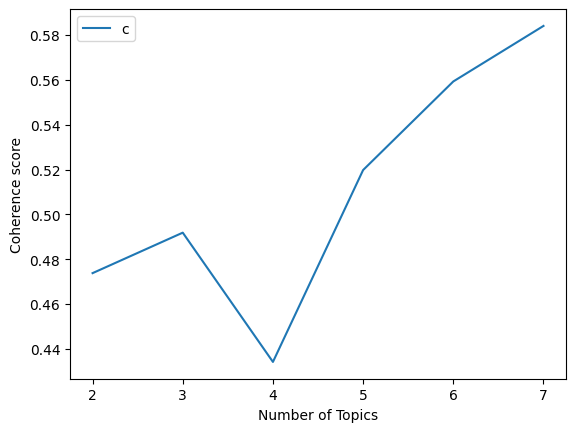

In [33]:
import matplotlib.pyplot as plt

#Show graph
limit = 8; start=2; step=1;
x=range(start,limit,step)
plt.plot(x,coherence_values_May)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence score')
plt.legend(('coherenve_values'), loc='best')

In [34]:
## Print the Coherence scores: 

for m, cv in zip(x, coherence_values_May):
    cv_round = round(cv,4)
    print(f"Number of topics: {m} has a Coherence of {cv_round}")

Number of topics: 2 has a Coherence of 0.4738
Number of topics: 3 has a Coherence of 0.4919
Number of topics: 4 has a Coherence of 0.4342
Number of topics: 5 has a Coherence of 0.5198
Number of topics: 6 has a Coherence of 0.5593
Number of topics: 7 has a Coherence of 0.5841
